In [1]:
import wobble
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

/Users/mbedell/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.minor.size'] = 3

In [3]:
MODEL_T_COLOR = '#1f77b4'
MODEL_STAR_COLOR = '#d62728'
DATA_COLOR = 'k'
COLOR3 = '#ff7f0e'

In [4]:
speed_of_light = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/speed_of_light) / (1. + v/speed_of_light)
    return np.sqrt(frac)

## 51 Peg:

In [5]:
results_51peg = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt3.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt3.hdf5


In [6]:
print(results_51peg.N)

91


### FIGURE: data and models for random epoch

In [7]:
o = [12,53,67]
r = np.arange(72)[np.isin(results_51peg.orders,o)] # index into results to get desired orders
e = 7 # epoch
n = np.where(results_51peg.epochs == e)[0][0] # index into results to get desired epoch

data_51peg = wobble.Data('/Users/mbedell/python/wobble/data/51peg_e2ds.hdf5',
                   orders=o, epochs=[e])

xs = np.exp(data_51peg.xs)
ys = np.exp(data_51peg.ys)
mask = np.array(data_51peg.ivars) <= 1.e-8

In [8]:
xstart = [4095, 5728, 6548]
xend = [4115, 5748, 6568]

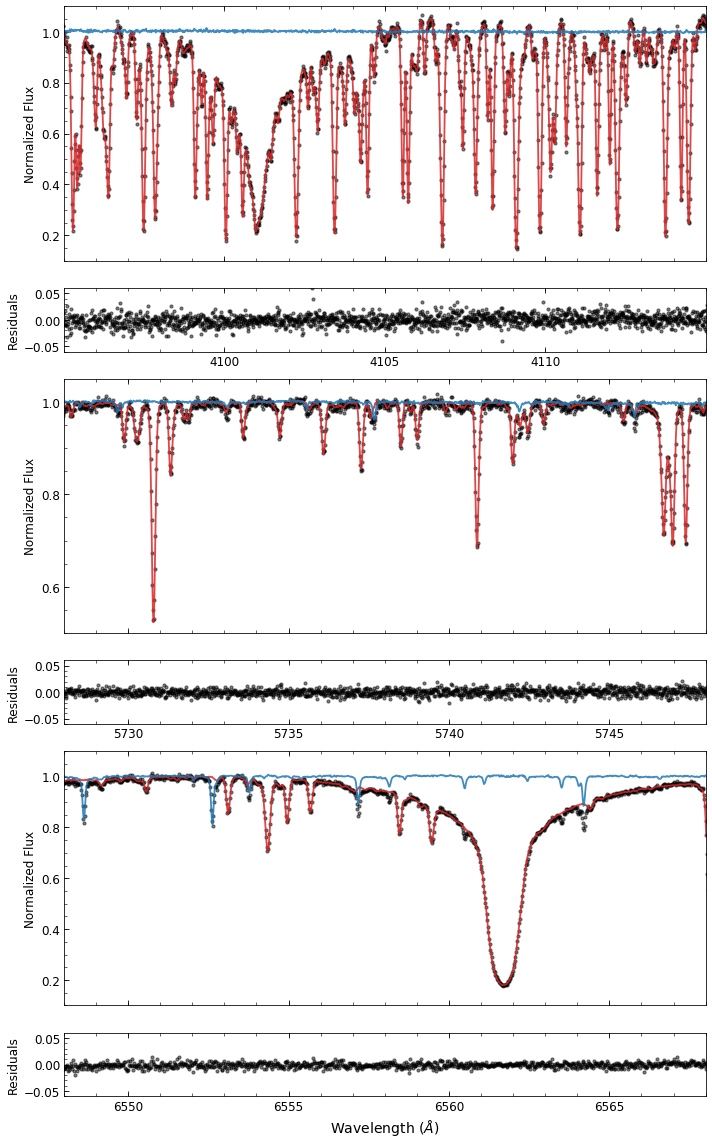

In [9]:
fig, axes = plt.subplots(6, 1, gridspec_kw = {'height_ratios':[4, 1, 4, 1, 4, 1]}, figsize=(10,16), sharex=False)
for i,r0 in enumerate(r):
    ax, ax2 = axes[2*i], axes[2*i+1]
    xs = np.ravel(np.exp(data_51peg.xs[i]))
    ys = np.ravel(np.exp(data_51peg.ys[i]))
    mask = np.ravel(data_51peg.ivars[i]) <= 1.e-8
    resids = ys - np.exp(results_51peg.star_ys_predicted[r0][n] 
                            + results_51peg.tellurics_ys_predicted[r0][n])
    ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
    ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
    ax.plot(xs, np.exp(results_51peg.star_ys_predicted[r0][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.8, alpha=0.85)
    ax.plot(xs, np.exp(results_51peg.tellurics_ys_predicted[r0][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.8, alpha=0.85)

    ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
    ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
    

    if i == 1:
        ax.set_ylim([0.5,1.05])
        ax.set_yticks(np.arange(0.6,1.1,0.2))
        ax.set_yticks(np.arange(0.5,1.05,0.05), minor=True)
    else:
        ax.set_ylim([0.1,1.1])
        ax.set_yticks(np.arange(0.2,1.1,0.2))
        ax.set_yticks(np.arange(0.1,1.15,0.05), minor=True)
    ax.set_xlim([xstart[i],xend[i]])
    ax.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 5))
    ax.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    #if i<2:
    ax2.set_ylim([-0.06, 0.06])
    ax2.set_yticks(np.arange(-0.05,0.06,0.05))
    ax2.set_yticks(np.arange(-0.06,0.06,0.01), minor=True)
    ax2.set_xlim([xstart[i],xend[i]])
    ax2.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 5))
    ax2.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    ax.set_xticklabels('')
    ax.set_ylabel('Normalized Flux', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
fig.tight_layout()
#fig.subplots_adjust(hspace=0.05)
plt.savefig('51peg_multispectrum.png')
plt.savefig('51peg_multispectrum.pdf')

### FIGURE: orbit fit

In [10]:
rvs = results_51peg.star_time_rvs # + results_51peg.bervs - results_51peg.drifts
pipeline_rvs = results_51peg.pipeline_rvs # + results_51peg.bervs
sigs = results_51peg.star_time_sigmas
pipeline_sigs = results_51peg.pipeline_sigmas
dates = np.copy(results_51peg.dates)

In [11]:
rvs -= np.median(rvs)
pipeline_rvs -= np.median(pipeline_rvs)
dates -= np.median(dates)

In [12]:
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

Mstar = 1.11 # Msun

In [13]:
t, rv, rv_err = dates, rvs, sigs

with pm.Model() as model:

    # Parameters
    logK = pm.Normal("logK", mu=np.log(55.11), sd=10.0)
    P = pm.Normal("P", mu=4.23078, sd=0.001)
    t0 = pm.Normal("t0", mu=np.median(t)+2., sd=50.)
    ecc = pm.Uniform("e", lower=0, upper=.99, testval=0.001)
    omega = xo.distributions.Angle("omega", testval=0.)
    logs = pm.Normal("logs", mu=np.log(np.median(rv_err)), sd=5.0)
    rv0 = pm.Normal("rv0", mu=0.0, sd=20.0, testval=0.)
    
    # Sanity check bounds
    pm.Potential("logK_bound", tt.switch(logK < -2., -np.inf, 0.0))
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Deterministic transformations
    K = pm.Deterministic("K", tt.exp(logK))
    s2 = tt.exp(2*logs)
    Mp = pm.Deterministic("Mp", K * tt.sqrt(1. - ecc**2.) * Mstar**(-2./3.) * P**(1./3.) / 203.) # assumes Mp << Mstar

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(t, K=K)
    pm.Deterministic("vrad", vrad)
    
    bkg = pm.Deterministic("bkg", rv0) # just in case...    
    rv_model = pm.Deterministic("rv_model", vrad + bkg)
    
    t_all = np.linspace(t.min()-5, t.max()+5, 1000)
    vrad_pred = orbit.get_radial_velocity(t_all, K=K)
    pm.Deterministic("vrad_pred", vrad_pred)
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     vrad_pred + bkg)

    # Compute the phased RV signal
    phase = np.linspace(-0.1, 1.1, 500)
    rvphase = orbit.get_radial_velocity(phase * P, K=K)
    pm.Deterministic("rvphase", rvphase)

    # Condition on the observations
    pm.Normal("obs", mu=rv_model, sd=tt.sqrt(tt.sqr(rv_err) + s2), observed=rv)
    par_wobble = pm.find_MAP()
    
    # Now do the trace
    sampler = xo.PyMC3Sampler(finish=200)
    burnin = sampler.tune(tune=5000, start=par_wobble)
    trace_wobble = sampler.sample(draws=5000)

logp = -162.91, ||grad|| = 209.46: 100%|██████████| 87/87 [00:00<00:00, 1827.72it/s]  
Sampling 4 chains: 100%|██████████| 208/208 [00:01<00:00, 123.35draws/s]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 9408/9408 [00:40<00:00, 231.91draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bkg, logs, omega, e, t0, P, logK]
Sampling 4 chains: 100%|██████████| 20800/20800 [01:36<00:00, 214.87draws/s]
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
There were 397 divergences after tuning. Increase `target_accept` or reparameterize.
There were 369 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6795004419890165, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples i

In [14]:
t, rv, rv_err = dates, pipeline_rvs, pipeline_sigs
with pm.Model() as model:

    # Parameters
    logK = pm.Normal("logK", mu=np.log(55.11), sd=10.0)
    P = pm.Normal("P", mu=4.23078, sd=0.001)
    t0 = pm.Normal("t0", mu=np.median(t)+2., sd=50.)
    ecc = pm.Uniform("e", lower=0, upper=.99, testval=0.001)
    omega = xo.distributions.Angle("omega", testval=0.)
    logs = pm.Normal("logs", mu=np.log(np.median(rv_err)), sd=5.0)
    rv0 = pm.Normal("rv0", mu=0.0, sd=20.0, testval=0.)
    
    # Sanity check bounds
    pm.Potential("logK_bound", tt.switch(logK < -2., -np.inf, 0.0))
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Deterministic transformations
    K = pm.Deterministic("K", tt.exp(logK))
    s2 = tt.exp(2*logs)
    Mp = pm.Deterministic("Mp", K * tt.sqrt(1. - ecc**2.) * Mstar**(-2./3.) * P**(1./3.) / 203.) # assumes Mp << Mstar
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(t, K=K)
    pm.Deterministic("vrad", vrad)
    
    bkg = pm.Deterministic("bkg", rv0) # just in case...    
    rv_model = pm.Deterministic("rv_model", vrad + bkg)
    
    t_all = np.linspace(t.min()-5, t.max()+5, 1000)
    vrad_pred = orbit.get_radial_velocity(t_all, K=K)
    pm.Deterministic("vrad_pred", vrad_pred)
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     vrad_pred + bkg)

    # Compute the phased RV signal
    phase = np.linspace(-0.1, 1.1, 500)
    rvphase = orbit.get_radial_velocity(phase * P, K=K)
    pm.Deterministic("rvphase", rvphase)

    # Condition on the observations
    pm.Normal("obs", mu=rv_model, sd=tt.sqrt(tt.sqr(rv_err) + s2), observed=rv)
    par_pipeline = pm.find_MAP()
    
    # Now do the trace
    sampler = xo.PyMC3Sampler(finish=200)
    burnin = sampler.tune(tune=4000, start=par_pipeline)
    trace_pipeline = sampler.sample(draws=5000)

logp = -118.26, ||grad|| = 1,684.9: 100%|██████████| 108/108 [00:00<00:00, 2077.41it/s] 
Sampling 4 chains: 100%|██████████| 9408/9408 [00:40<00:00, 99.49draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bkg, logs, omega, e, t0, P, logK]
Sampling 4 chains: 100%|██████████| 20800/20800 [01:16<00:00, 271.26draws/s]
There were 481 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6609067379793324, but should be close to 0.8. Try to increase the number of tuning steps.
There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6850970845205407, but should be close to 0.8. Try to increase the number of tuning steps.
There were 490 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not m

In [15]:
printname = {'K': '$K$ & m s$^{-1}$',
             'P': '$P$ & days',
             't0': '$t_0$ & JD',
             'e' : '$e$ & $-$ ',
             'omega' : '$\omega$ & rad',
             'logs' : '$s$ & m s$^{-1}$',
             'Mp' : '$m_p$ sin$i$ & $M_J$'
            }

for param in ['K', 'P', 't0', 'e', 'omega', 'logs']:
    pred_wobble = np.percentile(trace_wobble[param], [16, 50, 84], axis=0)
    pred_pipeline = np.percentile(trace_pipeline[param], [16, 50, 84], axis=0)
    if param == 'logs':
        pred_wobble = np.exp(pred_wobble)
        pred_pipeline = np.exp(pred_pipeline)
    if param == 't0':
        pred_wobble += np.median(results_51peg.dates)
        pred_pipeline += np.median(results_51peg.dates)
    wobble_vals = pred_wobble[1], pred_wobble[2] - pred_wobble[1], pred_wobble[1] - pred_wobble[0]
    pipeline_vals = pred_pipeline[1], pred_pipeline[2] - pred_pipeline[1], pred_pipeline[1] - pred_pipeline[0]
    if param == 'P':
        print('{0} & ${1:.4f}^{{+{2:.4f}}}_{{-{3:.4f}}}$ & ${4:.4f}^{{+{5:.4f}}}_{{-{6:.4f}}}$ \\\\'.format(printname[param], 
            *wobble_vals, *pipeline_vals))
    else:
        print('{0} & ${1:.2f}^{{+{2:.2f}}}_{{-{3:.2f}}}$ & ${4:.2f}^{{+{5:.2f}}}_{{-{6:.2f}}}$ \\\\'.format(printname[param], 
            *wobble_vals, *pipeline_vals))

$K$ & m s$^{-1}$ & $53.79^{+2.31}_{-2.14}$ & $54.10^{+1.79}_{-1.91}$ \\
$P$ & days & $4.2265^{+0.0004}_{-0.0004}$ & $4.2294^{+0.0003}_{-0.0003}$ \\
$t_0$ & JD & $2456546.86^{+0.03}_{-0.03}$ & $2456546.93^{+0.02}_{-0.01}$ \\
$e$ & $-$  & $0.04^{+0.02}_{-0.02}$ & $0.03^{+0.02}_{-0.02}$ \\
$\omega$ & rad & $0.18^{+0.64}_{-0.67}$ & $-1.76^{+0.30}_{-0.40}$ \\
$s$ & m s$^{-1}$ & $0.04^{+0.30}_{-0.04}$ & $0.72^{+0.07}_{-0.05}$ \\


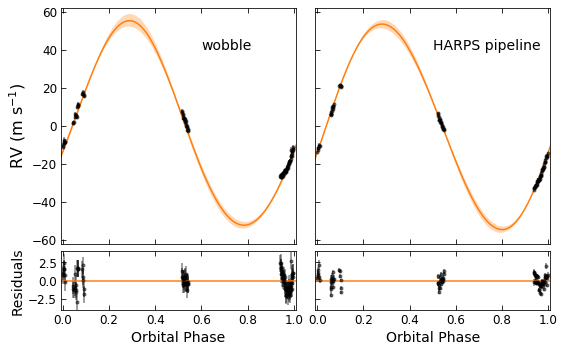

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw = {'height_ratios':[4, 1]}, 
                                         figsize=(8,5), sharex=True)

pred_wobble = np.percentile(trace_wobble["rvphase"], [16, 50, 84], axis=0)
phase_wobble = (dates % par_wobble["P"])/par_wobble["P"]
ax1.errorbar(phase_wobble, rvs - par_wobble['bkg'], 
             sigs, fmt='o', color=DATA_COLOR, alpha=0.5, ms=3)

ax1.plot(phase, pred_wobble[1], color=COLOR3)
art1 = ax1.fill_between(phase, pred_wobble[0], pred_wobble[2], color=COLOR3, alpha=0.3)
art1.set_edgecolor("none")

ax3.errorbar(phase_wobble, rvs - par_wobble['rv_model'], sigs, fmt='o', 
             color=DATA_COLOR, alpha=0.5, ms=3)
ax3.plot(phase, np.zeros_like(phase), color=COLOR3)

pred_pipeline = np.percentile(trace_pipeline["rvphase"], [16, 50, 84], axis=0)
phase_pipeline = (dates % par_pipeline["P"])/par_pipeline["P"]
ax2.errorbar(phase_pipeline, pipeline_rvs - par_pipeline['bkg'], 
             pipeline_sigs, fmt='o', color=DATA_COLOR, alpha=0.5, ms=3)
ax2.plot(phase, pred_pipeline[1], color=COLOR3)
art2 = ax2.fill_between(phase, pred_pipeline[0], pred_pipeline[2], color=COLOR3, alpha=0.3)
art2.set_edgecolor("none")

ax4.errorbar(phase_pipeline, pipeline_rvs - par_pipeline['rv_model'], pipeline_sigs, fmt='o', 
             color=DATA_COLOR, alpha=0.5, ms=3)
ax4.plot(phase, np.zeros_like(phase), color=COLOR3)

ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)
ax1.set_ylim([-62,62])
ax2.set_ylim([-62,62])
ax3.set_ylim([-4, 4])
ax3.set_xlim([-0.01,1.01])
ax4.set_ylim([-4, 4])
ax4.set_xlim([-0.01,1.01])

ax2.set_yticklabels('')
ax4.set_yticklabels('')

ax3.set_ylabel('Residuals', fontsize=14)
ax3.set_xlabel('Orbital Phase', fontsize=14)
ax4.set_xlabel('Orbital Phase', fontsize=14)

ax1.text(0.6, 40, 'wobble', fontsize=14)
ax2.text(0.5, 40, 'HARPS pipeline', fontsize=14)


fig.tight_layout()
fig.subplots_adjust(hspace=.05, wspace=.08)
plt.savefig('51peg_planet.png')
plt.savefig('51peg_planet.pdf')

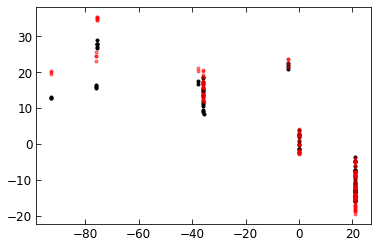

In [17]:
plt.plot(dates, rvs, 'k.')
plt.plot(dates, pipeline_rvs, 'r.', alpha=0.5)

## tellurics model 
#### (still using 51 Peg data)

### FIGURE: telluric basis vectors

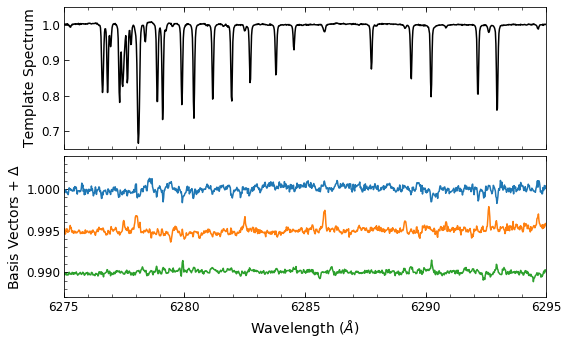

In [18]:
r = 63
xlim = [6275,6295]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[1, 1]}, 
                               figsize=(8,5), sharex=True)
ax1.plot(np.exp(results_51peg.tellurics_template_xs[r]),
       np.exp(results_51peg.tellurics_template_ys[r]), c='k')
for k in range(results_51peg.tellurics_K[r]):
    ax2.plot(np.exp(results_51peg.tellurics_template_xs[r]), 
            np.exp(results_51peg.tellurics_basis_vectors[r][k]) - 0.005*k)
ax1.set_xlim(xlim)
ax1.set_ylim([0.65,1.05])
ax2.set_xlim(xlim)
ax1.set_ylabel('Template Spectrum', fontsize=14)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel(r'Basis Vectors + $\Delta$', fontsize=14)
ax2.set_yticks(np.arange(0.990,1.005,0.005))
ax2.set_yticks(np.arange(0.987,1.005,0.001), minor=True)
ax2.set_xticks(np.arange(xlim[0],xlim[1]+1,5))
ax2.set_xticks(np.arange(xlim[0],xlim[1],1), minor=True)
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
plt.savefig('telluric_basis.png')

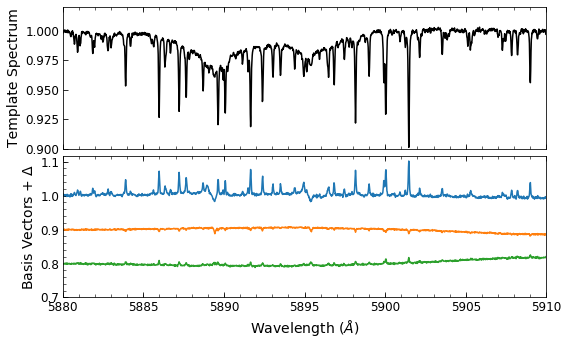

In [19]:
r = 56
xlim = [5880,5910]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[1, 1]}, 
                               figsize=(8,5), sharex=True)
ax1.plot(np.exp(results_51peg.tellurics_template_xs[r]),
       np.exp(results_51peg.tellurics_template_ys[r]), c='k')
for k in range(results_51peg.tellurics_K[r]):
    ax2.plot(np.exp(results_51peg.tellurics_template_xs[r]), 
            np.exp(results_51peg.tellurics_basis_vectors[r][k]) - 0.1*k)
ax1.set_xlim(xlim)
ax1.set_ylim([0.9,1.02])
ax2.set_xlim(xlim)
ax1.set_ylabel('Template Spectrum', fontsize=14)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel(r'Basis Vectors + $\Delta$', fontsize=14)
ax2.set_yticks(np.arange(0.7,1.1,0.1))
ax2.set_yticks(np.arange(0.7,1.1,0.02), minor=True)
ax2.set_xticks(np.arange(xlim[0],xlim[1]+1,5))
ax2.set_xticks(np.arange(xlim[0],xlim[1],1), minor=True)
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
plt.savefig('telluric_basis2.png')
plt.savefig('telluric_basis2.pdf')

### FIGURE: telluric basis weights

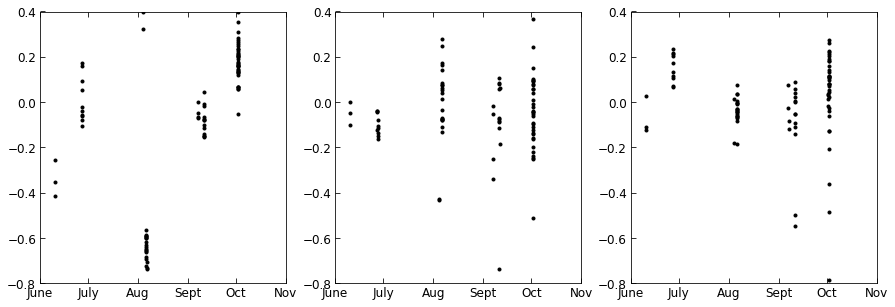

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
jan1_2003 = 2452640.5
for k,ax in enumerate(axes):
    ax.plot((results_51peg.dates - jan1_2003) % 365., results_51peg.tellurics_basis_weights[r][:,k], 'k.')
    ax.set_xticks([152, 182, 213, 244, 274, 305])
    ax.set_xticklabels(['June', 'July', 'Aug', 'Sept', 'Oct', 'Nov'])
    ax.set_ylim([-0.8,0.4])

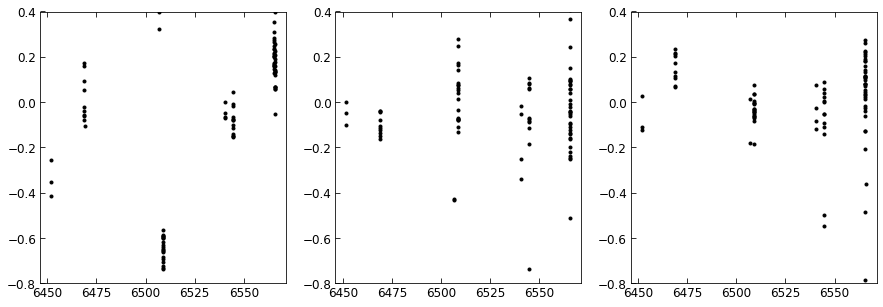

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for k,ax in enumerate(axes):
    ax.plot(results_51peg.dates - 2450000., results_51peg.tellurics_basis_weights[r][:,k], 'k.')
    #ax.set_xticks([152, 182, 213, 244, 274, 305])
    #ax.set_xticklabels(['June', 'July', 'Aug', 'Sept', 'Oct', 'Nov'])
    ax.set_ylim([-0.8,0.4])

### FIGURE: tellurics compared to standard star

In [22]:
from wobble.utils import fit_continuum
from astropy.io import fits
r = 63
xlim = [6275,6295]

In [24]:
spec_file = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T23_40_43.280_e2ds_A.fits'
wave_file = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T20_24_26.952_wave_A.fits'
sp = fits.open(spec_file)
flux = sp[0].data
sp2 = fits.open(wave_file)
wave = sp2[0].data
snr = sp[0].header['HIERARCH ESO DRS SPE EXT SN{0}'.format(str(int(r)))]
am = sp[0].header['AIRMASS']

In [25]:
am

1.18

In [26]:
o = 57
wave2,flux2 = np.exp(results_51peg.tellurics_template_xs[r]), \
              np.exp(results_51peg.tellurics_template_ys[r] * am)
wave1,flux1 = wave[r][:1500], flux[r][:1500] # HACK
ivars1 = np.zeros_like(flux1) + snr**2 # HACK
flux1 = np.exp(np.log(flux1) - fit_continuum(np.log(wave1), np.log(flux1), ivars1))

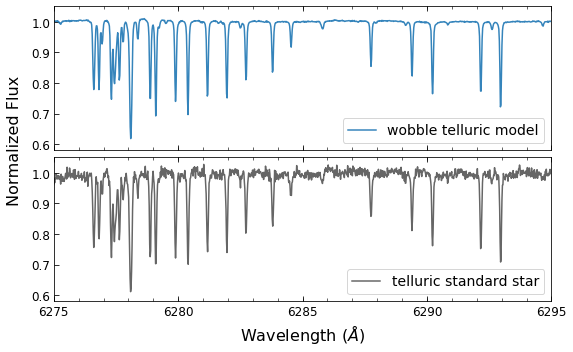

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[1, 1]}, 
                               figsize=(8,5), sharex=True)
ax2.plot(wave1,flux1+0.012,color=DATA_COLOR,alpha=0.6,label='telluric standard star')
ax1.plot(wave2,flux2,color=MODEL_T_COLOR,alpha=0.9,label='wobble telluric model')
ax2.set_xlim(xlim)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
ax1.set_ylabel(' ', fontsize=16) # hack to leave space for shared label
ax1.legend(loc='lower right', fontsize=14)
ax2.legend(loc='lower right', fontsize=14)
ax2.set_xticks(np.arange(xlim[0],xlim[1]+1,5))
ax2.set_xticks(np.arange(xlim[0],xlim[1],1), minor=True)
ax1.set_ylim([0.58,1.05])
ax2.set_ylim([0.58,1.05])
fig.text(0.01, 0.6, 'Normalized Flux', fontsize=16, rotation=90, verticalalignment='center')
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
fig.savefig('telluric_standard.png')
fig.savefig('telluric_standard.pdf')

## quiet M star:

In [28]:
results_barnards = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_barnards_Kstar0_Kt0.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_barnards_Kstar0_Kt0.hdf5


### FIGURE: data and models for random epoch

In [31]:
o = [12,53,67]
r = np.arange(63)[np.isin(results_barnards.orders,o)] # index into results to get desired orders
e = 54 # epoch
#n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch
n = e

data_barnards = wobble.Data('/Users/mbedell/python/wobble/data/barnards_e2ds.hdf5',
                   orders=o, epochs=[e])

xs = np.exp(data_barnards.xs)
ys = np.exp(data_barnards.ys)
mask = np.array(data_barnards.ivars) <= 1.e-8

In [32]:
xstart = [4095, 5728, 6548]
xend = [4115, 5748, 6568]

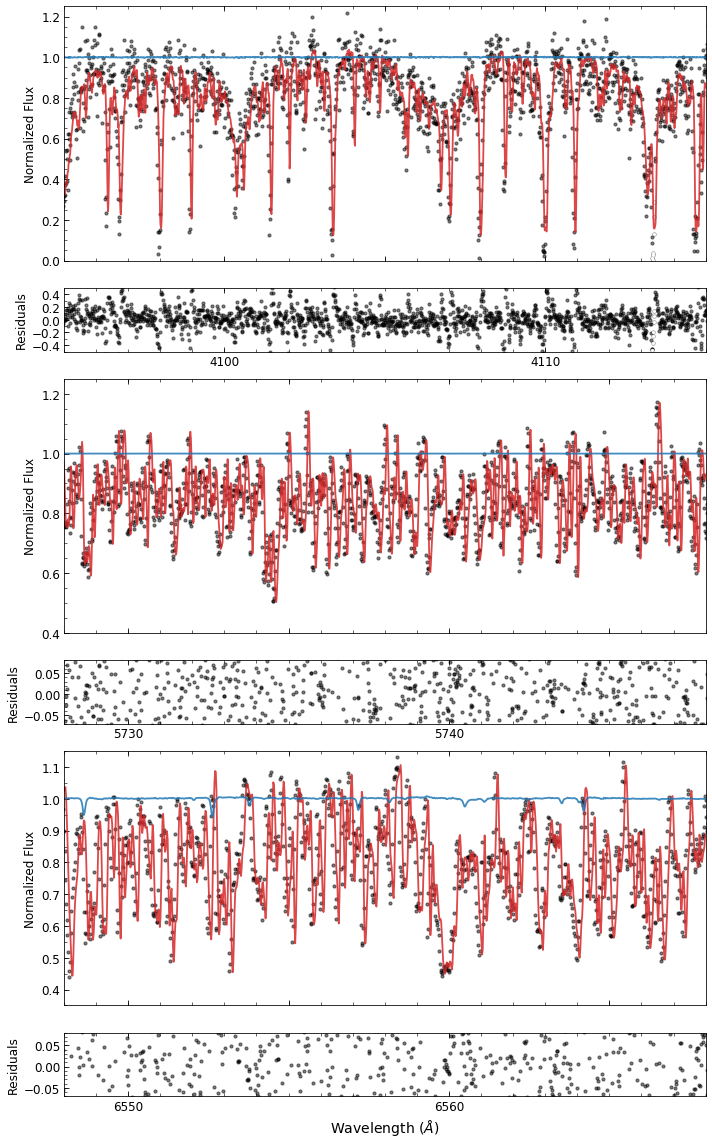

In [33]:
fig, axes = plt.subplots(6, 1, gridspec_kw = {'height_ratios':[4, 1, 4, 1, 4, 1]}, figsize=(10,16), sharex=False)
for i,r0 in enumerate(r):
    ax, ax2 = axes[2*i], axes[2*i+1]
    xs = np.ravel(np.exp(data_barnards.xs[i]))
    ys = np.ravel(np.exp(data_barnards.ys[i]))
    mask = np.ravel(data_barnards.ivars[i]) <= 1.e-8
    resids = ys - np.exp(results_barnards.star_ys_predicted[r0][n] 
                            + results_barnards.tellurics_ys_predicted[r0][n])
    ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
    ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
    ax.plot(xs, np.exp(results_barnards.star_ys_predicted[r0][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.8, alpha=0.85)
    ax.plot(xs, np.exp(results_barnards.tellurics_ys_predicted[r0][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.8, alpha=0.85)

    ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
    ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
    

    
    ax.set_ylim([0.35,1.15])
    ax.set_yticks(np.arange(0.4,1.2,0.1))
    ax.set_yticks(np.arange(0.35,1.2,0.05), minor=True)
    if i==1:
        ax.set_ylim([0.4,1.25])
        ax.set_yticks(np.arange(0.4,1.4,0.2))
        ax.set_yticks(np.arange(0.4,1.2,0.05), minor=True)        
    if i==0:
        ax.set_ylim([0.0,1.25])
        ax.set_yticks(np.arange(0.0,1.4,0.2))
        ax.set_yticks(np.arange(0.0,1.2,0.05), minor=True)
    ax.set_xlim([xstart[i],xend[i]])
    ax.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 5))
    ax.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    ax2.set_ylim([-0.07, 0.07])
    ax2.set_yticks(np.arange(-0.05,0.06,0.05))
    ax2.set_yticks(np.arange(-0.07,0.08,0.01), minor=True)
    if i==0:
        ax2.set_ylim([-0.5, 0.5])
        ax2.set_yticks(np.arange(-0.4,0.5,0.2))
        ax2.set_yticks(np.arange(-0.5,0.5,0.1), minor=True)
    ax2.set_xlim([xstart[i],xend[i]])
    ax2.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 10))
    ax2.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    ax.set_xticklabels('')
    ax.set_ylabel('Normalized Flux', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
fig.tight_layout()
#fig.subplots_adjust(hspace=0.05)
plt.savefig('barnards_multispectrum.png')
plt.savefig('barnards_multispectrum.pdf')

### FIGURE: tellurics zoom-in

In [ ]:
o = 63 # order
r = np.where(results_barnards.orders == o)[0][0] # index into results to get desired order
e = 20 # epoch
n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch

data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o], epochs=[e])

xs_barnards = np.exp(data_barnards.xs[0][0])
ys_barnards = np.exp(data_barnards.ys[0][0])
mask_barnards = data_barnards.ivars[0][0] <= 1.e-8
predicted_barnards = np.exp(results_barnards.star_ys_predicted[r][n] 
                            + results_barnards.tellurics_ys_predicted[r][n])
resids_barnards = ys_barnards - predicted_barnards

In [ ]:
data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o])
print(results_barnards.epochs[results_barnards.airms > 1.6])

In [ ]:
print(results_barnards.airms[n])

In [ ]:
o = 63 # order
r1 = np.where(results_51peg.orders == o)[0][0] # index into results to get desired order
e = 41 # epoch
n1 = np.where(results_51peg.epochs == e)[0][0] # index into results to get desired epoch

data_51peg = wobble.Data('51peg_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o], epochs=[e])

xs_51peg = np.exp(data_51peg.xs[0][0])
ys_51peg = np.exp(data_51peg.ys[0][0])
mask_51peg = data_51peg.ivars[0][0] <= 1.e-8
predicted_51peg = np.exp(results_51peg.star_ys_predicted[r1][n1] 
                            + results_51peg.tellurics_ys_predicted[r1][n1])
resids_51peg = ys_51peg - predicted_51peg

In [ ]:
print(results_51peg.airms[n1])

In [ ]:
fig, ((ax,ax3), (ax2,ax4)) = plt.subplots(2, 2, gridspec_kw = {'height_ratios':[5, 1]}, figsize=(12,6), sharex=True)

ax.scatter(xs_51peg, ys_51peg, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax.scatter(xs_51peg[mask_51peg], ys_51peg[mask_51peg], marker=".", alpha=1., c='white', s=20)
ax.plot(xs_51peg, predicted_51peg, lw=1.5, alpha=0.7, color='k')
ax.plot(xs_51peg, np.exp(results_51peg.star_ys_predicted[r1][n1]) + 0.6, 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.8)
ax.plot(xs_51peg, np.exp(results_51peg.tellurics_ys_predicted[r1][n1]) + 1.2, 
                color=MODEL_T_COLOR, label='tellurics model', lw=2.5, alpha=0.8)
ax.set_ylabel('Normalized Flux + const.', fontsize=14, labelpad=12)

ax2.scatter(xs_51peg, resids_51peg, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax2.scatter(xs_51peg[mask_51peg], resids_51peg[mask_51peg], marker=".", alpha=1., c='white', s=20)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax3.scatter(xs_barnards, ys_barnards - 0.1, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax3.scatter(xs_barnards[mask_barnards], ys_barnards[mask_barnards] - 0.1, marker=".", alpha=1., c='white', s=20)
ax3.plot(xs_barnards, predicted_barnards - 0.1, lw=1.5, alpha=0.7, color='k')
ax3.plot(xs_barnards, np.exp(results_barnards.star_ys_predicted[r][n]) + 0.6, 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.8)
ax3.plot(xs_barnards, np.exp(results_barnards.tellurics_ys_predicted[r][n]) + 1.2, 
                color=MODEL_T_COLOR, label='tellurics model', lw=2.5, alpha=0.8)

ax4.scatter(xs_barnards, resids_barnards, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax4.scatter(xs_barnards[mask_barnards], resids_barnards[mask_barnards], marker=".", alpha=1., c='white', s=20)
ax4.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)

ax.set_ylim([0.15,2.45])
ax.set_yticks(np.arange(0.2,2.45,0.2))
ax.set_yticks(np.arange(0.15,2.45,0.05), minor=True)
ax3.set_ylim([0.15,2.45])
ax3.set_yticks(np.arange(0.2,2.45,0.2))
ax3.set_yticks(np.arange(0.15,2.45,0.05), minor=True)
ax3.set_yticklabels('')

ax2.set_ylim([-0.06, 0.06])
ax2.set_yticks(np.arange(-0.05,0.06,0.05))
ax2.set_yticks(np.arange(-0.06,0.06,0.01), minor=True)
ax4.set_ylim([-0.06, 0.06])
ax4.set_yticks(np.arange(-0.05,0.06,0.05))
ax4.set_yticks(np.arange(-0.06,0.06,0.01), minor=True)
ax4.set_yticklabels('')


ax.set_xlim([6301,6315.5])
ax.set_xticks(np.arange(6302, 6315, 2))
ax.set_xticks(np.arange(6301, 6316, 0.5), minor=True)

ax.text(6302.2, 2.26, 'tellurics model', fontsize=14)
ax.text(6302.2, 1.66, 'star model', fontsize=14)
ax.text(6302.2, 1.06, 'data & composite model', fontsize=14)
ax.set_title('51 Peg', fontsize=16)
ax3.set_title('Barnard\'s Star', fontsize=16)

#ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.02)
plt.savefig('telluric_comparison.png')
plt.savefig('telluric_comparison.pdf')

### FIGURE: comparison to PHOENIX model

In [ ]:
from astropy.io import fits
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03300-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_3300k = np.copy(hdul[0].data)
hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
model_ys_3200k = np.copy(hdul[0].data)
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-5.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_55logg = np.copy(hdul[0].data)
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_45logg = np.copy(hdul[0].data)
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-4.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_40logg = np.copy(hdul[0].data)
hdul = fits.open('/Users/mbedell/python/wobble/data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
model_xs = np.copy(hdul[0].data)

In [ ]:
o = 24 # order
r = np.where(results_barnards.orders == o)[0][0] # index into results to get desired order
e = 216 # epoch
n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch

data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o], epochs=[e])

xs = np.exp(data_barnards.xs[0][0])
ys = np.exp(data_barnards.ys[0][0])
mask = data_barnards.ivars[0][0] <= 1.e-8
resids = ys - np.exp(results_barnards.star_ys_predicted[r][n] 
                            + results_barnards.tellurics_ys_predicted[r][n])

In [ ]:
v_sys = 219.e3 # from eyeballing the Balmer region (4020-4050A)

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(xs / doppler(v_sys), ys, 'k.', ms=5, alpha=0.6, label='data')
ax.plot(xs / doppler(v_sys), np.exp(results_barnards.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, lw=1.5, alpha=0.9, label='wobble star model')
ax.plot(model_xs, model_ys_3200k/0.75e13, c=COLOR3, lw=1.5, alpha=0.9, label='PHOENIX model')
ax.set_xlim([4450,4465])


ax.set_xticks(np.arange(4450, 4466, 5))
ax.set_xticks(np.arange(4450, 4465, 0.5), minor=True)
ax.set_ylim([-0.02,1.4])
ax.set_yticks(np.arange(0.0,1.6,0.2))
ax.set_yticks(np.arange(0.0,1.5,0.05), minor=True)
ax.legend(fontsize=14)

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Normalized Flux', fontsize=14);
plt.savefig('barnards_model.png')
plt.savefig('barnards_model.pdf');

### FIGURE: time series

In [34]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

coord = SkyCoord(ra=269.4486, dec=4.7379807, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.01, u.degree)
height = u.Quantity(0.01, u.degree)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
star = r[r['source_id'] == 4472832130942575872]
rv_gaia = -110.51 * u.km / u.s # from Gaia DR2 docs

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Query finished.


In [35]:
pm = np.sqrt(star['pmra'][0]**2 + star['pmdec'][0]**2)
pm = (pm * u.mas / u.yr).to(u.arcsec / u.yr)
dist = (1./star['parallax'][0] * u.kpc).to(u.pc)
vt = (4.74 * dist * pm).value * u.km / u.s # decompose doesn't work here
min_dist = dist/np.sqrt(1. + rv_gaia**2/vt**2)
v = np.sqrt(rv_gaia**2 + vt**2)
obstime = Time(star['ref_epoch'][0], format='decimalyear')
min_dist_time = obstime + np.sqrt(dist**2 - min_dist**2)/v

In [36]:
def predict_rv(date):
    t = (date - min_dist_time).jd * u.day # now relative to time of closest approach
    x = v**2 * t/np.sqrt(v**2 * t**2 + min_dist**2)
    return x.to(u.m / u.s)

In [37]:
predict_dates = np.append(2454000., results_barnards.dates)
predict_dates = np.append(predict_dates, 2457000.)
predicted_rvs = np.array([predict_rv(d).value for d in Time(predict_dates, format='jd')])

In [38]:
# this part isn't needed anymore because I cut out all post-upgrade spectra when running:
post_upgrade = results_barnards.dates >= 2457174.5 # June 2015
pre_upgrade = results_barnards.dates < 2457174.5

In [43]:
data_barnards = wobble.Data('/Users/mbedell/python/wobble/data/barnards_e2ds.hdf5')

In [46]:
rvs = results_barnards.star_time_rvs #+ results_barnards.bervs - results_barnards.drifts
pipeline_rvs = results_barnards.pipeline_rvs #+ results_barnards.bervs
sigs = results_barnards.star_time_sigmas
pipeline_sigs = results_barnards.pipeline_sigmas

wobble_resids = rvs - predicted_rvs[1:-1]
wobble_resids -= np.median(wobble_resids)
pipeline_resids = pipeline_rvs - predicted_rvs[1:-1]
pipeline_resids -= np.median(pipeline_resids)

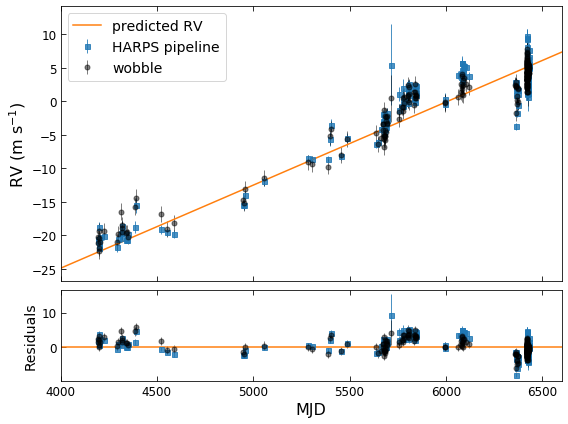

In [47]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3, 1]}, 
                              figsize=(8,6), sharex=True)
ax.plot(predict_dates - 2450000, predicted_rvs - np.mean(predicted_rvs), 
        c=COLOR3, label='predicted RV')

ax.errorbar(results_barnards.dates - 2450000, pipeline_rvs - np.mean(pipeline_rvs), 
             pipeline_sigs, fmt='s', color=MODEL_T_COLOR, alpha=0.8, ms=5, elinewidth=1, label='HARPS pipeline')
ax.errorbar(results_barnards.dates - 2450000, rvs - np.mean(rvs), 
             sigs, fmt='o', color=DATA_COLOR, alpha=0.5, ms=5, elinewidth=1, label='wobble')
ax.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)

ax2.axhline(0.0, c=COLOR3)
ax2.errorbar(results_barnards.dates - 2450000, pipeline_resids, 
             pipeline_sigs, fmt='s', color=MODEL_T_COLOR, alpha=0.8, ms=5, elinewidth=1)
ax2.errorbar(results_barnards.dates - 2450000, wobble_resids, 
             sigs, fmt='o', color=DATA_COLOR, alpha=0.5, ms=5, elinewidth=1)

ax2.set_xlabel('MJD', fontsize=16)
ax2.set_ylabel('Residuals', fontsize=14)

ax2.set_xlim([4000,6600])

ax.legend(fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('barnards_rvs.png')
plt.savefig('barnards_rvs.pdf');

In [48]:
np.std(pipeline_resids)#, np.std(pipeline_resids_post)

2.5160711014428325

In [49]:
np.std(wobble_resids)#, np.std(wobble_resids_post)

1.962683120375124